In [2]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [3]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.datasets import make_multilabel_classification
# Import of keras model and hidden layers for our convolutional network

In [4]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/dataset/leapGestRecog/leapGestRecog"

In [5]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)    
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 4, 4, ..., 3, 4, 2],
        [5, 4, 5, ..., 3, 3, 3],
        [4, 5, 4, ..., 4, 5, 3],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 7, 4],
        [4, 7, 5, ..., 5, 4, 4]], dtype=uint8),
 0]

In [6]:
# shuffle the input data
import random
random.shuffle(image_data)

In [7]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
input_data[:5]

[array([[ 5,  6,  6, ...,  5,  4,  5],
        [ 5,  6,  7, ...,  4,  3,  3],
        [ 6,  7,  7, ...,  4,  4,  4],
        ...,
        [ 8,  9, 11, ...,  4,  4,  4],
        [ 9, 10, 12, ...,  5,  4,  5],
        [ 8,  9, 11, ...,  3,  3,  5]], dtype=uint8),
 array([[4, 4, 5, ..., 4, 3, 3],
        [4, 5, 5, ..., 3, 3, 3],
        [5, 5, 6, ..., 4, 4, 3],
        ...,
        [4, 5, 6, ..., 4, 5, 4],
        [5, 5, 6, ..., 3, 5, 5],
        [4, 4, 5, ..., 4, 5, 4]], dtype=uint8),
 array([[ 6,  5,  5, ...,  4,  3,  4],
        [ 5,  5,  6, ...,  5,  4,  3],
        [ 4,  4,  5, ...,  4,  3,  3],
        ...,
        [27, 26, 31, ...,  5,  5,  5],
        [24, 23, 28, ...,  4,  4,  4],
        [18, 23, 25, ...,  5,  4,  5]], dtype=uint8),
 array([[6, 5, 5, ..., 5, 4, 5],
        [6, 4, 6, ..., 4, 3, 4],
        [4, 5, 5, ..., 4, 4, 4],
        ...,
        [4, 4, 5, ..., 4, 5, 4],
        [4, 5, 5, ..., 5, 5, 4],
        [6, 4, 4, ..., 4, 4, 4]], dtype=uint8),
 array([[4, 4, 5, ..., 4

In [8]:
label[:10]

[0, 6, 2, 1, 7, 0, 6, 3, 5, 8]

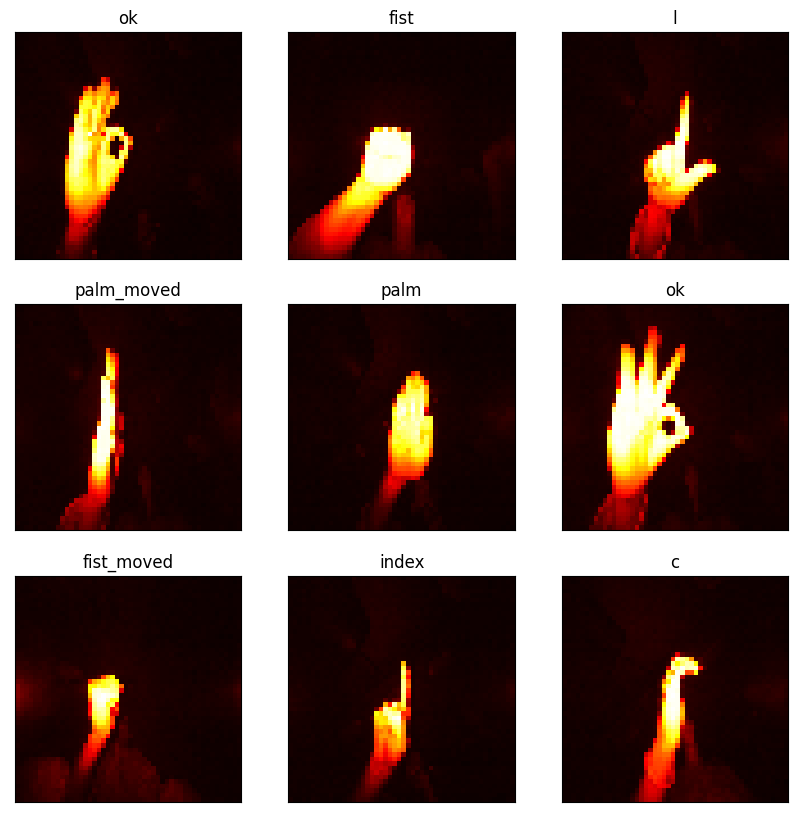

In [9]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
#plt.show()

In [10]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [11]:
from sklearn.datasets import make_multilabel_classification
X,y=make_multilabel_classification(n_samples=500,n_features=4,n_classes=2,n_labels=3,random_state=1)
X

array([[ 9., 12.,  6., 12.],
       [ 5.,  2., 12., 22.],
       [15.,  5., 12., 11.],
       ...,
       [ 5., 10., 15., 28.],
       [ 0.,  8., 16., 27.],
       [ 6.,  9., 13., 22.]])

In [12]:
X=(X-X.min())/(X.max()-X.min())
X

array([[0.20454545, 0.27272727, 0.13636364, 0.27272727],
       [0.11363636, 0.04545455, 0.27272727, 0.5       ],
       [0.34090909, 0.11363636, 0.27272727, 0.25      ],
       ...,
       [0.11363636, 0.22727273, 0.34090909, 0.63636364],
       [0.        , 0.18181818, 0.36363636, 0.61363636],
       [0.13636364, 0.20454545, 0.29545455, 0.5       ]])

In [13]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [14]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.10, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

In [16]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int8)

In [17]:

classes, counts = np.unique(y_train, return_counts=True)

classes

array([0, 1], dtype=int8)

In [18]:
# # Plotting class distribution
# plt.barh(CATEGORIES, counts)
# plt.title('Class distribution in training set')
# plt.xlabel('Count')
# plt.ylabel('Classes')
# plt.show()

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(50,50,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  # Mengubah konfigurasi MaxPooling2D
    
    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),  # Mengubah konfigurasi MaxPooling2D
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
         optimizer = 'rmsprop',
        #  optimizer = 'adam',
         metrics = ['accuracy'])

In [38]:
r = model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
563/563 [==============================] - 139s 245ms/step - loss: 1.4331 - accuracy: 0.4298 - val_loss: 0.1999 - val_accuracy: 0.9545
Epoch 2/7
563/563 [==============================] - 123s 218ms/step - loss: 0.1483 - accuracy: 0.9672 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 3/7
563/563 [==============================] - 120s 212ms/step - loss: 0.0545 - accuracy: 0.9886 - val_loss: 0.0369 - val_accuracy: 0.9900
Epoch 4/7
563/563 [==============================] - 123s 219ms/step - loss: 0.0357 - accuracy: 0.9928 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 5/7
563/563 [==============================] - 116s 205ms/step - loss: 0.0184 - accuracy: 0.9974 - val_loss: 1.0057e-04 - val_accuracy: 1.0000
Epoch 6/7
563/563 [==============================] - 112s 199ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 1.3117e-05 - val_accuracy: 1.0000
Epoch 7/7
563/563 [==============================] - 115s 205ms/step - loss: 0.0125 - accuracy: 0.9980 - val_loss: 4.9604e

In [39]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 10, 10, 96)        11712     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 5, 5, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 5, 5, 256)         614656    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_68 (Conv2D)          (None, 2, 2, 384)       

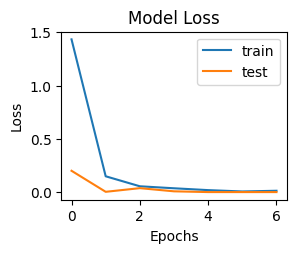

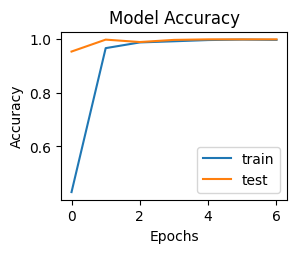

In [40]:
plt.subplot(2, 2, 1)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

63/63 [==============================] - 1s 17ms/step - loss: 4.9604e-05 - accuracy: 1.0000
Test accuracy: 100.00%


In [42]:
# val_loss, val_accuracy = model.evaluate(X_val, y_val)

# print('Val accuracy: {:2.2f}%'.format(val_accuracy*100))

63/63 [==============================] - 1s 16ms/step


[]

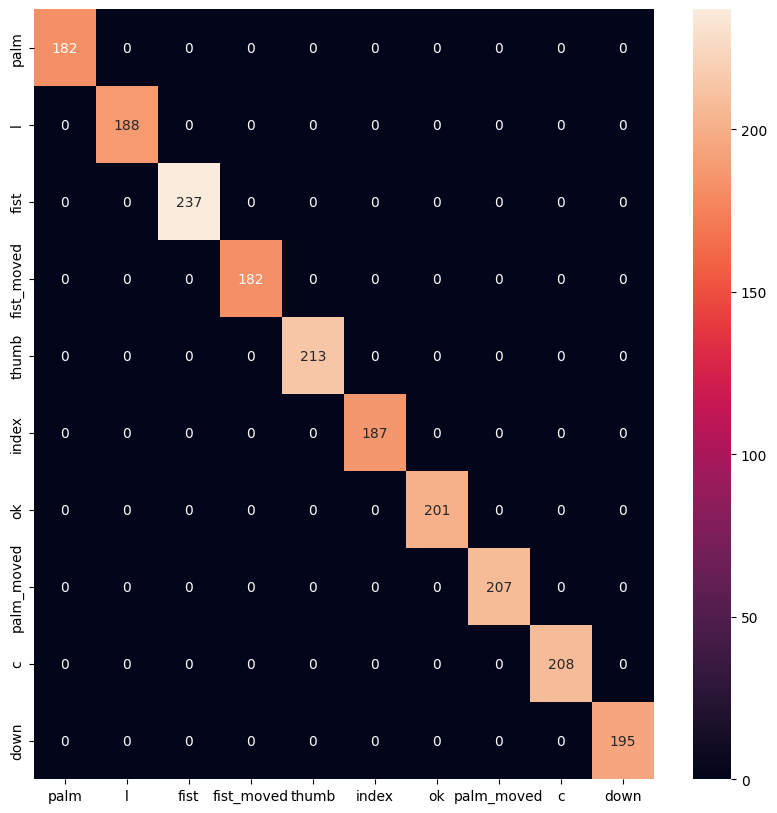

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in CATEGORIES]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,fmt='d',xticklabels=cat, yticklabels=cat)
plt.plot()

In [44]:
# # Load the image and resize it to 32x32 pixels
# import requests


# # image1 = Image.open('/content/gdrive/MyDrive/img/cat.jpg')
# #image = Image.open('/content/asd.jpg')

# url = input("Masukan url: ")
# r = requests.get(url, stream=True)  # Download
# image1 = np.array(Image.open(r.raw))

# image = image1.resize((32, 32))

# # Convert the image to a numpy array and normalize its values
# image_array = np.array(image) / 255.0

# # Reshape the image array to (1, 32, 32, 3)
# image_array = image_array.reshape((1, 32, 32, 3))

# # Pass the image through the model to get the predicted class probabilities
# predictions = model.predict(image_array)

# # Get the index of the predicted class with the highest probability
# predicted_class = np.argmax(predictions[0])

# # Get the corresponding label from the class_names list
# label = CATEGORIES[predicted_class]

# plt.imshow(image1)
# plt.show()



1/1 [==============================] - 0s 29ms/step


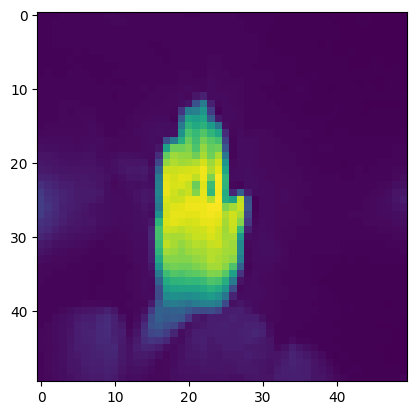

Label : palm


In [45]:
# Load the image and resize it to 32x32 pixels
image1 = Image.open('image/ut.png')
#image = Image.open('/content/asd.jpg')
image = image1.convert('L')
image = image.resize((50, 50))
plt.imshow(image)
# Convert the image to a numpy array and normalize its values
image_array = np.array(image) / 255.0


image_array = image_array.reshape((1, 50, 50, 1))  


# Pass the image through the model to get the predicted class probabilities
predictions = model.predict(image_array)

# Get the index of the predicted class with the highest probability
predicted_class = np.argmax(predictions[0])

if predicted_class == 0 :
    label = "palm"
else :
    label = "No Palm"
    
# Get the corresponding label from the class_names list
# label = CATEGORIES[predicted_class]



plt.imshow(image)
plt.show()

print("Label :", label)



